In [1]:
# create three chaos models 
import numpy as np
import matplotlib.pyplot as plt
class ChaosAttractors():
    """
    Initial conditions for the systems to display chaotic behaviour are 
    defined as follows:

    Lorenz 63 -> s = 10, r = 8/3, b = 28 and dt = 0.01
    Fabrikant-Rabinovich -> a = 0.14, g = 0.1 and dt = 0.01
    Rossler -> a = 0.2, b = 0.2, c = 6.3 and dt = 0.01 
    """
    def __init__(self, steps, lrz_s=10, lrz_r=28, lrz_b=8/3, lrz_dt = 0.01, 
                 rab_fab_a = 0.14, rab_fab_g = 0.1, rab_fab_dt = 0.01,
                 ros_a=0.2, ros_b=0.2, ros_c=6.3, ros_dt = 0.01):
        self.lrz_s = lrz_s
        self.lrz_b = lrz_b
        self.lrz_r = lrz_r
        self.lrz_dt = lrz_dt
        self.rab_fab_a = rab_fab_a
        self.rab_fab_g = rab_fab_g
        self.rab_fab_dt = rab_fab_dt
        self.ros_a = ros_a
        self.ros_b = ros_b
        self.ros_c = ros_c
        self.ros_dt = ros_dt
        self.steps = steps
        
    """Lorenz 63 System"""    
    def lorenz63(self):
        xs = np.empty((self.steps + 1,))
        ys = np.empty((self.steps + 1,))
        zs = np.empty((self.steps + 1,))
        
        xs[0], ys[0], zs[0] = (1.0, 1.0, 1.0)
        for i in range(self.steps):
            x_dot = self.lrz_s*(ys[i] - xs[i])
            y_dot = self.lrz_r*xs[i] - ys[i] - xs[i]*zs[i]
            z_dot = xs[i]*ys[i] - self.lrz_b*zs[i]
            xs[i + 1] = xs[i] + (x_dot * self.lrz_dt)
            ys[i + 1] = ys[i] + (y_dot * self.lrz_dt)
            zs[i + 1] = zs[i] + (z_dot * self.lrz_dt)
        return xs, ys, zs
    
    """Rabinovich–Fabrikant equations"""
    def rabinovich_fabrikant(self):
        xs = np.zeros((self.steps))
       	ys = np.zeros((self.steps))
       	zs = np.zeros((self.steps))
       	xs[0] ,ys[0] ,zs[0] = (-1,0,0.5)
       	
       	for i in range(1,self.steps):
       		x = xs[i-1]
       		y = ys[i-1]
       		z = zs[i-1]
       		dx = y*(z - 1 + x*x) + self.rab_fab_g*x
       		dy = x*(3*z + 1 - x*x) + self.rab_fab_g *y
       		dz = -2*z*(self.rab_fab_a  + x*y)
       		xs[i] = x+self.rab_fab_dt*dx
       		ys[i] = y+self.rab_fab_dt*dy
       		zs[i] = z+self.rab_fab_dt*dz
        return xs, ys, zs
    
    """Rossler Hyperchaotic System"""
    def rossler(self):
        xs = np.empty([self.steps + 1])
        ys = np.empty([self.steps + 1])
        zs = np.empty([self.steps + 1])
        xs[0], ys[0], zs[0] = (1.0, 1.0, 1.0)
        
        for i in range(self.steps):
            x_dot = -ys[i] - zs[i]
            y_dot = xs[i] + self.ros_a*ys[i]
            z_dot = self.ros_b + xs[i]*zs[i] - self.ros_c*zs[i]
            xs[i+1] = xs[i] + (x_dot * self.ros_dt)
            ys[i+1] = ys[i] + (y_dot * self.ros_dt)
            zs[i+1] = zs[i] + (z_dot * self.ros_dt)
        return xs, ys, zs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from netCDF4 import Dataset as NetCDFFile
import random
import timeit
import pickle
from scipy import stats
import xarray as xr
import pandas as pd
import statistics
from scipy import interpolate
import os
import pytz, datetime
import multiprocessing as mp


In [12]:
# generate data
# Define length of the chaotic time series
attractors_series  = ChaosAttractors(6000)
# Obtain the time series for the Lorenz systems
lorenz_x, lorenz_y, lorenz_z = attractors_series.lorenz63()

lorenz_x = np.reshape(lorenz_x,[np.size(lorenz_x),1])[1000:,]
lorenz_y = np.reshape(lorenz_y,[np.size(lorenz_y),1])[1000:,] 
lorenz_z = np.reshape(lorenz_z,[np.size(lorenz_z),1])[1000:,]

data     = np.concatenate([lorenz_x,lorenz_y,lorenz_z],axis=1)

(5001, 3)

Computing spectral radius...
done.


/var/folders/jg/7hc7yjgn1jxf7t4jbvm7g9640000gw/T/ipykernel_71875/34361151.py:57: LinAlgWarning: Ill-conditioned matrix (rcond=1.30585e-17): result may not be accurate.
  Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize),


MSE = [0.21280633 0.52351374 0.79311076]


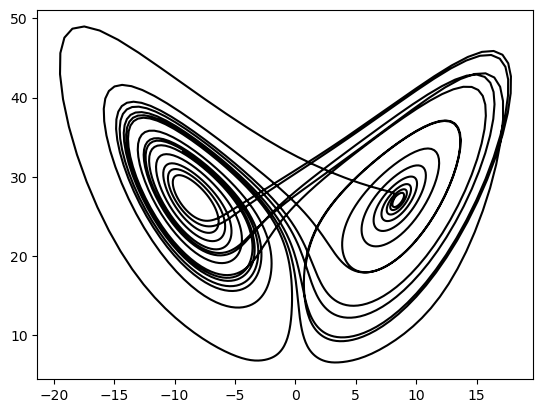

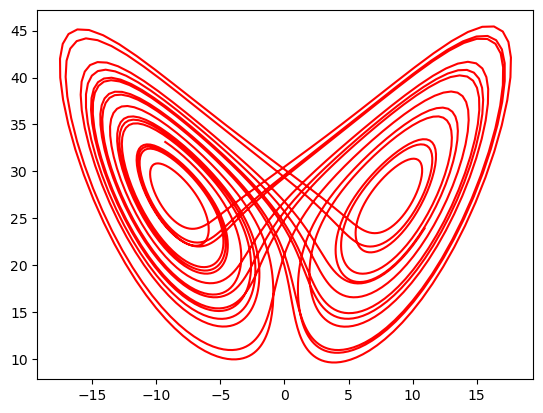

In [4]:
# 3-D case
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
from https://mantas.info/code/simple_esn/
(c) 2012-2020 Mantas LukoÅ¡eviÄius
Distributed under MIT license https://opensource.org/licenses/MIT
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 
# numpy.linalg is also an option for even fewer dependencies

# load the data
trainLen = 2050
testLen  = 2000
initLen = 100
#data = np.loadtxt('/content/MackeyGlass_t17.txt')


# generate the ESN reservoir
inSize = outSize = 3
resSize = 2000
a = 0.3 # leaking rate
np.random.seed()
Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
W = np.random.rand(resSize,resSize) - 0.5 
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

# allocated memory for the design (collected states) matrix
X = np.zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1] 

# run the reservoir with the data and collect X
x = np.zeros((resSize,1))
for t in range(trainLen):
    u = data[t,:]
    u = np.reshape(u,[inSize,1])
    unit = np.ones((1,1))
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u))) + np.dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]
    
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), 
    np.dot(X,Yt.T) ).T




# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize,testLen))
u = data[trainLen,:]
u = np.reshape(u,[inSize,1])
x_record = x
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((unit,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = np.squeeze(y)
    # generative mode:
    u = y
    u = np.reshape(u,[inSize,1])
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - np.transpose(Y[:,0:errorLen]) ) ) / errorLen
print('MSE = ' + str( mse ))
    
# model output
plt.figure()
plt.plot(Y[0,:],Y[2,:],'k')
# ground truth
plt.figure()
plt.plot(data[trainLen+1:trainLen+testLen+1,0],data[trainLen+1:trainLen+testLen+1,2],'r')

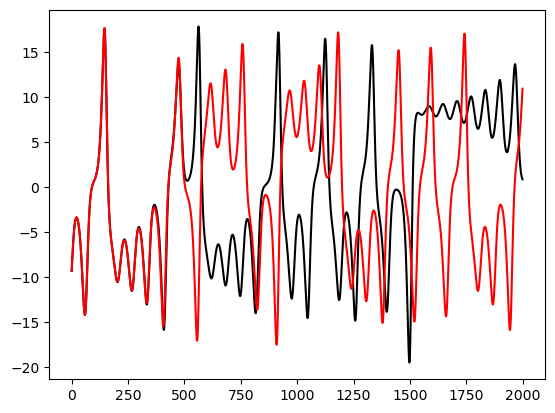

In [5]:
plt.plot(Y[0,:],'k')
plt.plot(data[trainLen+1:trainLen+testLen+1,0],'r')